# Transfer Learning Model 'DenseNet201' #

In [28]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.applications.densenet import DenseNet201, preprocess_input


In [2]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     train_path = os.path.join(base_dir, 'train')
     valid_path = os.path.join(base_dir, 'valid')

     # instantiate data generators
     datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

     train_gen = datagen.flow_from_directory(train_path,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(valid_path,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary')

     return train_gen, val_gen


In [4]:
# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)


input = Input(input_shape)

# get the pretrained model, cut out the top layer
pretrained = DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')
#pretrained.summary()

In [5]:
# if the pretrained model it to be used as a feature extractor, and not for
# fine-tuning, the weights of the model can be frozen in the following way
for layer in pretrained.layers: # The last four layers are trainable [:-4]
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in pretrained.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001493D5DE5F8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001493D5DEA58> False
<keras.layers.convolutional.Conv2D object at 0x000001493D5DEC50> False
<keras.layers.normalization.BatchNormalization object at 0x000001493D5DE908> False
<keras.layers.core.Activation object at 0x000001493D5DEAC8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001493D5DEEF0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001493D5DEBE0> False
<keras.layers.normalization.BatchNormalization object at 0x000001493D5EB3C8> False
<keras.layers.core.Activation object at 0x000001493D795710> False
<keras.layers.convolutional.Conv2D object at 0x000001493D700128> False
<keras.layers.normalization.BatchNormalization object at 0x000001493D7E7668> False
<keras.layers.core.Activation object at 0x000001493D897048> False
<keras.layers.convolutional.Conv2D object at 0x000001493D800E48> False
<keras.layers.merge.Concatenate object a

In [6]:
output = pretrained(input)
output = GlobalAveragePooling2D()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(input, output)

# note the lower lr compared to the cnn example
model.compile(SGD(lr=0.001, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

# print a summary of the model on screen
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Model)          (None, 3, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [7]:
# get the data generators
train_gen, val_gen = get_pcam_generators("C:\\Users\\s165635\\Desktop\\Project Imaging (8P361)\\Dataset CHAMELYON16")


# save the model and weights
model_name = 'my_first_transfer_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [8]:
# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model, note that we define "mini-epochs"
train_steps = train_gen.n//train_gen.batch_size//20
val_steps = val_gen.n//val_gen.batch_size//20

# since the model is trained for only 10 "mini-epochs", i.e. half of the data is
# not used during training
history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=callbacks_list)

Epoch 1/10
225/225 [==============================] - 825s 4s/step - loss: 0.5873 - acc: 0.7142 - val_loss: 0.6876 - val_acc: 0.6625

Epoch 00001: val_loss improved from inf to 0.68755, saving model to my_first_transfer_model_weights.hdf5
Epoch 2/10
225/225 [==============================] - 768s 3s/step - loss: 0.5254 - acc: 0.7675 - val_loss: 1.1288 - val_acc: 0.5600

Epoch 00002: val_loss did not improve from 0.68755
Epoch 3/10
225/225 [==============================] - 757s 3s/step - loss: 0.5145 - acc: 0.7647 - val_loss: 0.6609 - val_acc: 0.7087

Epoch 00003: val_loss improved from 0.68755 to 0.66086, saving model to my_first_transfer_model_weights.hdf5
Epoch 4/10
225/225 [==============================] - 854s 4s/step - loss: 0.5159 - acc: 0.7689 - val_loss: 0.9027 - val_acc: 0.6475

Epoch 00004: val_loss did not improve from 0.66086
Epoch 5/10
225/225 [==============================] - 773s 3s/step - loss: 0.5088 - acc: 0.7663 - val_loss: 0.7593 - val_acc: 0.6637

Epoch 00005: v

5/5 [==============================] - 15s 3s/step
done
No of errors = 1/16000


C:\Users\s165635\AppData\Local\Continuum\anaconda3\envs\DeepLearning_CPU\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


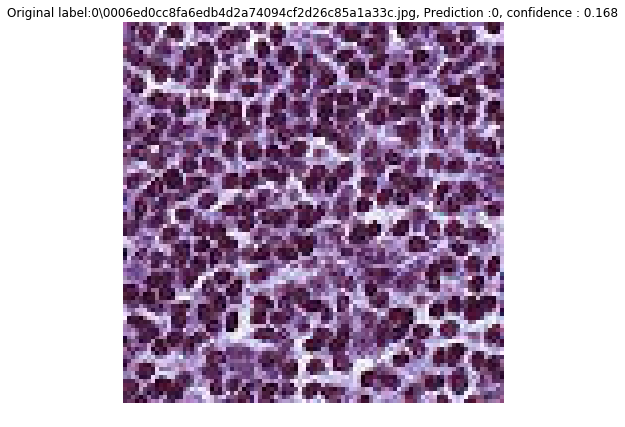

In [30]:
# Create a generator for prediction
#validation_generator = val_gen()
 
# Get the filenames from the generator
fnames = val_gen.filenames
base_dir = "C:\\Users\\s165635\\Desktop\\Project Imaging (8P361)\\Dataset CHAMELYON16"
valid_path = os.path.join(base_dir, 'valid')

# Get the ground truth from generator
ground_truth = val_gen.classes
 
# Get the label to class mapping from the generator
label2index = val_gen.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(val_gen, steps=5,verbose=1) #change steps here
predicted_classes = np.argmax(predictions,axis=1)
print("done")
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),val_gen.samples))
 
# Show the errors
for i in range(len(errors)): 
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    #img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    original = cv2.imread('{}/{}'.format(valid_path,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some specialization. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations.

You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.

The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.
1 => no dropout // 0 => all dropout
